<a href="https://colab.research.google.com/github/yueliyl/mcgill-kyoto-2025/blob/main/mcgill_kyoto_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised learning of single-cell transcriptome data using NMF and ETM

In this assignment, you will directly modify the code blocks as instructed below to implement and experiment non-negative matrix factorization (NMF) and embedded topic model (ETM) on a single-cell RNA-seq datasets.

For the rest of the codeblocks, simply click through them **without making any change**. You need to read and understand each codeblock. But we will only grade the assigned code blocks and the desired outputs.

You are recommended to run the code using Colab. By the default Colab connects to a CPU node. To speed up the training, you may connect with a T4 GPU by choosing 'Runtime' in the top menu and then clicking on 'Change runtime type' and choose 'T4 GPU'. Note that for free Google account, we can keep the notebook connected to a GPU for at most 12 hours. Nonetheless, all the training and inference required to complete this assignment can be done within 5 minutes even with a CPU.

If you have a good GPU-equipped Windows or Mac computer, you may connect to Local Runtime:

1. Install Jupyter Package for Colab: in Terminal with bash shell, do

  ```
  pip install jupyter_http_over_ws
  jupyter serverextension enable --py jupyter_http_over_ws
  ```
  
2. In Terminal, start a Jupyter Notebook instance on your local machine:
```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --no-browser
```
Copy one of the URLs generated as a token. From my side, it looks like this `http://localhost:8888/?token=[long string]`

3. Connect to Local Runtime in Colab:
  1. Open your Colab notebook and select Connect → Connect to local runtime.
  2. When prompted with local URL, paste the token URL you got from step 2.

After this setup, Colab will connect to the local Jupyter Notebook server, allowing you to utilize your local machine's resources while running the notebook on Google Colab's interface.

In my experiments, I used a Macbook Pro with M1 Max and 64 GB RAM. The speed is comparable to the T4 GPU and much faster than the default CPU on Colab.


In [1]:
#@title Install scanpy for single-cell data analysis
!pip install scanpy

In [2]:
#@title Install igraph and louvain needed for clustering evaluation below
!pip install python-igraph
!pip install louvain

In [3]:
#@title Import all required libraries for this assignment
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

import os
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from seaborn import heatmap, lineplot, clustermap
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import igraph as ig
import louvain as lv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

If you running locally and get ModuleNotFoundError when importing any of the above packages, do pip install them into your system.

# Mouse Pancreas single-cell RNA-sequencing data
The folder a4_data contains the single-cell Mouse Pancreas dataset obtained from Baron et al (2016) study. The dataset has 1886 cells measured over 4194 genes by scRNA-seq and were processed and filtered for the purpose of this assignment. Here are the individual files:

* `MP.pickle`: The single-cell expression count matrix (matrix of integers) of dimension 1886 cells by 4194 genes plus 2 columns indicating the batch IDs and cell types
* `MP_genes.pickle`: gene names for the 4194 genes
* `sample_info.csv`: a 1886 by 3 information matrix with the rows as the1886 cells and columns for the cell IDs, batch IDs (not used in this assignment), and cell type labels
* `cell_IDs.pkl`: cell IDs as a list of strings

The code block below loads the scRNA-seq data into a Pandas DataFrame `df` as well as the M gene names `genes` using a Python library called `pickle`. It then reorders the rows and columns and save the final $N\times M$ matrix $X$ into a Numpy `ndarray` for our subsequent matrix factorization tasks.

In addition, using `anndata` library we create an AnnData object called `mp_anndata`, which as the input ndarray matrix $X$ and the ground-truth cell type labels for the 1886 cells for evaluation purpose.

In [4]:
# If run on Colab cloud compute (default), uncomment this code
# from google.colab import drive
# drive.mount('/content/drive')

# # change this to the path where the data are saved on your Google Drive
# !git clone https://github.com/yueliyl/mcgill-kyoto-2025/content/drive/MyDrive/mcgill-kyoto-2025
# filepath = "/content/drive/MyDrive/mcgill-kyoto-2025/"

# If running on local runtime, uncomment this change the file path if needed
filepath = "~/Documents/Talks/McGill-Kyoto-2025/tut/"
filepath = os.path.expanduser(filepath)

# Extract to the current directory
import zipfile
with zipfile.ZipFile(filepath+'MP.pickle.zip', 'r') as zip_ref:
    zip_ref.extractall(filepath)

# mouse pancreas single-cell dataset
# read in data and cell type labels
with open(filepath+'MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open(filepath+'MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open(filepath+'cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv(filepath+'sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

# Evaluating clustering by adjusted Rand Index
Adjusted Rand Index (ARI) is a common metric used to evaluate the unsupervised clustering by comparing the consistency between the predicted clusters and the ground-truth clusters (i.e., cell type labels in this assignment).

The function `evaluate_ari(cell_embed, adata)` below takes $N\times K$ input cell embedding `cell_embed` with $K$ as the embedding dimensions and the annotated cell label data as `adata`. It first runs UMAP to compute the distance between cells based on their embeddings and then run Louvain clustering using the cells-cells distance matrix from UMAP to cluster cells into groups defined by the resolution parameter (default: 0.15). Finally, it computes the ARI based on the Louvain clusters and the ground-truth cell type using `adjusted_rand_score` from `Scikit-learn`.

We will be using `evaluate_ari` to evaluate the cell embedding quality by NMF and ETM.

In [5]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

# Task 1 NMF with SSE loss

Implement the NMF function `nmf_sse` based on Lecture 13 slide 19. A function header, Docstring, and function call have been written for you.

Your implementation can be in either Numpy or PyTorch. The latter is much faster when running on a GPU.

Note that the NMF takes an input matrix of dimension $M\times N$ with $M$ genes and $N$ samples whereas the input matrix $X$ is a $N\times M$ dimension. Also, the matrix $H$ is a $K\times N$ matrix where the `evaluate_ari(cell_embed, adata)` above expects the cell embedding to have dimension $N\times K$. So you will need to provide these functions with the transposed of $X$ and $H$, respectively.

Besides returning the final matrices $W$ and $H$, save the mean squared error (MSE) $MSE = ||X-WH||_2^2/(N*M)$ and ARI at each iteration into a 3-column ndarray called `perf` with the first column as the iteration index and return `perf` as the third output from the function `nmf_sse`.

Run your NMF for 100 iterations and return $W$, $H$, and `perf` for the following analyses. This should take less than 3 minutes depending on your local computer. This should takes less than a minute to finish.

In [8]:
#@title NMF with SSE loss function
def nmf_sse(X, K, adata=mp_anndata, niter=100):
    """
    NMF with sum of squared error loss as the objective
    :param X: M x N input matrix (numpy array)
    :param K: low rank
    :param adata: annotated X matrix with cluster labels for evaluating ARI
    :param niter: number of iterations to run
    :return:
        1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
        2. niter-by-3 tensor with iteration index, SSE, and ARI as the 3 columns
    """

    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    M, N = X.shape
    W = torch.rand(M, K, device=device)
    H = torch.rand(K, N, device=device)
    X = torch.from_numpy(np.array(X, dtype="float32"))

    # Ensure X, W, and H are on the correct device
    X = X.to(device)
    W = W.to(device)
    H = H.to(device)

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

    for i in range(niter):

        # Update H and W with element-wise multiplication and division
        H = H * (W.T @ X) / (W.T @ W @ H + 1e-10)  # Adding a small constant to avoid division by zero
        W = W * (X @ H.T) / (W @ (H @ H.T) + 1e-10)

        # Calculate the performance metrics
        reconstruction = W @ H
        sse = torch.sum((reconstruction - X) ** 2) / (X.size(0) * X.size(1))
        H_np = H.T.cpu().numpy() if H.is_cuda else H.T.numpy()
        ari = evaluate_ari(H_np, adata)

        # Store iteration, SSE, and ARI
        perf[i, 0] = i
        perf[i, 1] = sse
        perf[i, 2] = ari

        print(f"Iter: {i} .. MSE: {sse:.4f} .. ARI: {ari:.4f}")

    return W.cpu().numpy(), H.cpu().numpy(), perf.cpu()

In [9]:
W_nmf_sse, H_nmf_sse, nmf_sse_perf = nmf_sse(X.T, K, niter=100)

Iter: 0 .. MSE: 30.4557 .. ARI: 0.0000
Iter: 1 .. MSE: 3.6039 .. ARI: 0.1220
Iter: 2 .. MSE: 3.0145 .. ARI: 0.1214
Iter: 3 .. MSE: 2.7212 .. ARI: 0.1069
Iter: 4 .. MSE: 2.4025 .. ARI: 0.1265
Iter: 5 .. MSE: 2.2352 .. ARI: 0.2656
Iter: 6 .. MSE: 2.0617 .. ARI: 0.2650
Iter: 7 .. MSE: 1.9001 .. ARI: 0.4114
Iter: 8 .. MSE: 1.7777 .. ARI: 0.2490
Iter: 9 .. MSE: 1.6935 .. ARI: 0.2807
Iter: 10 .. MSE: 1.6433 .. ARI: 0.3621
Iter: 11 .. MSE: 1.6098 .. ARI: 0.3616
Iter: 12 .. MSE: 1.5829 .. ARI: 0.3123
Iter: 13 .. MSE: 1.5578 .. ARI: 0.3691
Iter: 14 .. MSE: 1.5325 .. ARI: 0.3138
Iter: 15 .. MSE: 1.5068 .. ARI: 0.3665
Iter: 16 .. MSE: 1.4820 .. ARI: 0.3733
Iter: 17 .. MSE: 1.4598 .. ARI: 0.3725
Iter: 18 .. MSE: 1.4408 .. ARI: 0.3710
Iter: 19 .. MSE: 1.4242 .. ARI: 0.3698
Iter: 20 .. MSE: 1.4092 .. ARI: 0.3689
Iter: 21 .. MSE: 1.3950 .. ARI: 0.4101
Iter: 22 .. MSE: 1.3808 .. ARI: 0.3391
Iter: 23 .. MSE: 1.3668 .. ARI: 0.4149
Iter: 24 .. MSE: 1.3544 .. ARI: 0.3654
Iter: 25 .. MSE: 1.3448 .. ARI: 0.

# Monitor training progress
THe function called `monitor_perf` below is completed and provided to you. It displays the SSE and ARI at each iteration from the above NMF-SSE training. If your above NMF implementation is correct, you will observe that the SSE drops quite rapidly at the first few iterations and the ARI increases in a zigzag way because it is an independent metric from the training objective.

Use plot below as your reference. Although you may see a different progress with different random initialization of $W$ and $H$, the behaviour of your implemented NMF model should be very similar and this is true for all of the following tasks.

We are going to use `monitor_perf` to monitor the performances of the other two models that we are going to implement next.

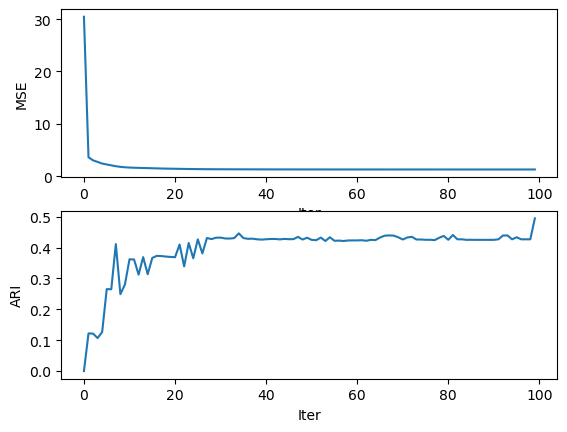

In [10]:
#@title Monitor ARI and objective function
def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'SSE', 'Poisson', or 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """
    perf = pd.DataFrame(data=perf, columns=['Iter', objective, 'ARI'])
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=False)
    lineplot(data=perf, x="Iter", y=objective, ax=ax1)
    lineplot(data=perf, x="Iter", y="ARI", ax=ax2)
    if path == "":
        plt.show()
    else:
        plt.savefig(path)

monitor_perf(nmf_sse_perf, "MSE")

# Task 2 NMF with log Poisson likelihood
Implement the NMF function `nmf_psn` that maximizes the log Poisson likelihood w.r.t. $W$ and $H$ s.t. $W,H\ge0$ based on Lecture 13 slide 53.

Your implementation can be in either Numpy or PyTorch. The latter is much faster when running on a GPU.

Save the average log Poisson likelihood $(X\log WH - WH)/(N\times M)$ and ARI at each iteration.

Note that because the NMF algorithm requires element-wise division, to avoid dividing by zeros, you can set the zero values to a small value like so: `np.where(A > 0, A, 1e-16)`.


In [11]:
#@title NMF Poisson likelihood
def nmf_psn(X, K, adata=mp_anndata, niter=100):
    """
    NMF with log Poisson likelihood as the objective
    :param X: M x N input matrix
    :param K: low rank
    :param adata: annotated X matrix with cluster labels for evaluating ARI
    :param niter: number of iterations to run
    :return:
        1. updated W and H that minimize log Poisson likelihood
        2. niter-by-3 tensor with iteration index, Loglik, and ARI as the 3 columns
    """
    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    M, N = X.shape
    W = torch.rand(M, K, device=device)
    H = torch.rand(K, N, device=device)
    X = torch.from_numpy(np.array(X, dtype="float32"))

    # Ensure X, W, and H are on the correct device
    X = X.to(device)
    W = W.to(device)
    H = H.to(device)

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

    for i in range(niter):

        # Compute intermediate values with small constants to prevent division by zero
        WT1 = W.T @ torch.ones((X.size(0), X.size(1)), device=device)
        X_hat = W @ H
        H = H * (W.T @ (X / (X_hat + 1e-16))) / (WT1 + 1e-16)

        oneHT = torch.ones((X.size(0), X.size(1)), device=device) @ H.T
        X_hat = W @ H
        W = W * ((X / (X_hat + 1e-16)) @ H.T) / (oneHT + 1e-16)

        # Ensure X_hat remains positive
        X_hat = W @ H
        X_hat = torch.where(X_hat > 0, X_hat, torch.tensor(1e-16, device=device))

        # Calculate log Poisson likelihood and ARI
        log_likelihood = torch.sum(X * torch.log(X_hat) - X_hat) / (X.size(0) * X.size(1))

        # Convert H to NumPy for ARI evaluation
        H_np = H.T.cpu().numpy() if H.is_cuda else H.T.numpy()
        ari = evaluate_ari(H_np, adata) if adata is not None else 0  # Placeholder if no `adata`

        # Store iteration, Loglik, and ARI
        perf[i, 0] = i
        perf[i, 1] = log_likelihood
        perf[i, 2] = ari

        print(f"Iter: {i} .. Loglik: {log_likelihood:.4f} .. ARI: {ari:.4f}")

    return W.cpu().numpy(), H.cpu().numpy(), perf.cpu()

Train your implemented NMF-Poisson

In [12]:
W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, K, niter=100)

Iter: 0 .. Loglik: -0.1631 .. ARI: 0.0000
Iter: 1 .. Loglik: -0.1470 .. ARI: 0.1310
Iter: 2 .. Loglik: -0.1258 .. ARI: 0.1439
Iter: 3 .. Loglik: -0.1044 .. ARI: 0.1469
Iter: 4 .. Loglik: -0.0843 .. ARI: 0.1464
Iter: 5 .. Loglik: -0.0622 .. ARI: 0.2209
Iter: 6 .. Loglik: -0.0397 .. ARI: 0.5697
Iter: 7 .. Loglik: -0.0235 .. ARI: 0.5852
Iter: 8 .. Loglik: -0.0141 .. ARI: 0.5854
Iter: 9 .. Loglik: -0.0086 .. ARI: 0.6481
Iter: 10 .. Loglik: -0.0049 .. ARI: 0.6498
Iter: 11 .. Loglik: -0.0019 .. ARI: 0.6504
Iter: 12 .. Loglik: 0.0007 .. ARI: 0.6499
Iter: 13 .. Loglik: 0.0030 .. ARI: 0.6569
Iter: 14 .. Loglik: 0.0050 .. ARI: 0.8970
Iter: 15 .. Loglik: 0.0068 .. ARI: 0.8899
Iter: 16 .. Loglik: 0.0084 .. ARI: 0.8941
Iter: 17 .. Loglik: 0.0098 .. ARI: 0.8872
Iter: 18 .. Loglik: 0.0111 .. ARI: 0.8970
Iter: 19 .. Loglik: 0.0122 .. ARI: 0.8879
Iter: 20 .. Loglik: 0.0132 .. ARI: 0.8711
Iter: 21 .. Loglik: 0.0141 .. ARI: 0.8663
Iter: 22 .. Loglik: 0.0149 .. ARI: 0.8775
Iter: 23 .. Loglik: 0.0157 .. AR

Check your implementation with `monitor_perf`.

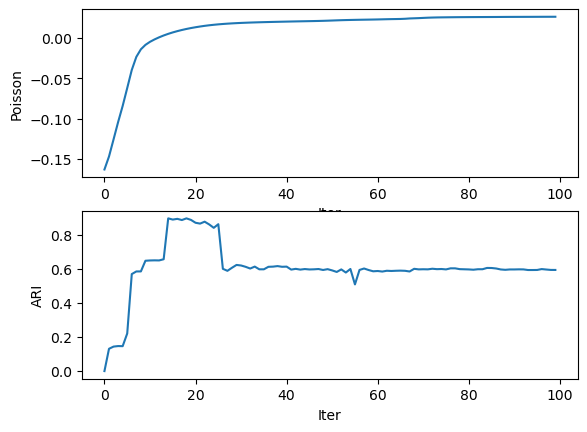

In [13]:
monitor_perf(nmf_psn_perf, "Poisson")

# Compare NMF-SSE and NMF-Poisson
Comparing the two models, we observe that the NMF-Poisson model led to higher ARI than the NMF-SSE model. This implies that the Poisson likelihood is a better objective function to model the discrete read counts of the scRNA-seq data than the SSE loss. The latter is equivalent to maximizing the log of Gaussian likelihood.

Text(0, 0.5, 'ARI')

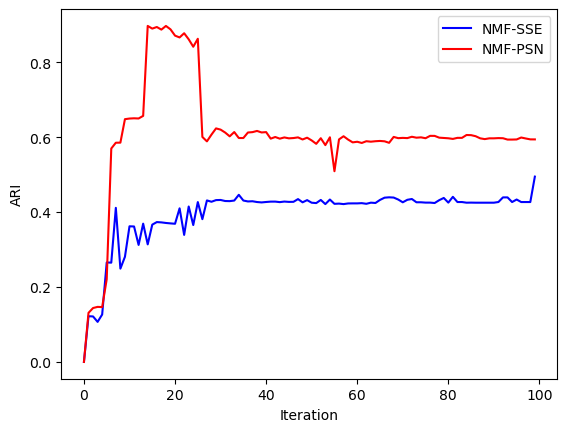

In [14]:
# compare NMF-SSE and NMF-Poisson
fig, ax = plt.subplots()
nmf_sse_perf_df = pd.DataFrame(data=nmf_sse_perf, columns=['Iter', "SSE", 'ARI'])
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
ax.plot(nmf_sse_perf_df["Iter"], nmf_sse_perf_df["ARI"], color='blue', label='NMF-SSE')
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.legend()
plt.xlabel("Iteration");
plt.ylabel("ARI")

# Embedding Topic Model (ETM)
The codeblock bleow implements a simpler strip-down version of the scETM (Zhao et al, 2021). The code is the same as the original ETM implementation by Dieng et al (2020) that is available from \url{https://github.com/adjidieng/ETM}.


In [15]:
# @title ETM implementation (DO NOT MODIFY)
class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, emsize,
                    theta_act, embeddings=None, train_embeddings=True, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.emsize = emsize
        self.t_drop = nn.Dropout(enc_drop)

        self.theta_act = self.get_activation(theta_act)

        self.train_embeddings = train_embeddings

        ## define the word embedding matrix \rho
        if self.train_embeddings:
            self.rho = nn.Parameter(torch.randn(vocab_size, rho_size)) # V x L
        else:
            self.rho = embeddings.clone().float().to(device) # V x L

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)#nn.Parameter(torch.randn(rho_size, num_topics))

        ## define variational distribution for \theta_{1:D} via amortizartion
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                self.theta_act,
                nn.Linear(t_hidden_size, t_hidden_size),
                self.theta_act,
            )
        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def get_activation(self, act):
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        elif act == 'softplus':
            act = nn.Softplus()
        elif act == 'rrelu':
            act = nn.RReLU()
        elif act == 'leakyrelu':
            act = nn.LeakyReLU()
        elif act == 'elu':
            act = nn.ELU()
        elif act == 'selu':
            act = nn.SELU()
        elif act == 'glu':
            act = nn.GLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act

    # theta ~ mu + std N(0,1)
    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)

        # KL[q(theta)||p(theta)] = lnq(theta) - lnp(theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):

        ## softmax over vocab dimension
        beta = F.softmax(self.alphas(self.rho), dim=0).transpose(1, 0)
        return beta

    def get_theta(self, normalized_bows):
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        return theta, kld_theta

    def decode(self, theta, beta):
        res = torch.mm(theta, beta)
        preds = torch.log(res+1e-6)
        return preds

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta


The code to instantiate an ETM model object is already written for you with pre-specified hyperparameters (i.e., topic number, hidden size, learning rates, weight decay penalty, etc). You want to start with these settings. Once you get the model working, you may play around with these parameters to get higher ARI. But that is not mandatory.


In [16]:
model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            emsize=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)

# Task 3 Implementing ETM
Implement the wrapper function called `train_ETM` that uses the helper functions `train_ETM_helper` to train a ETM and another completed helper function called `get_theta` to compute cell embedding topic mixture $\mathbf{\theta}$. The latter two functions have been provided to you. **Do not modify them**.

Note here that `get_theta` takes the normalized gene counts by the total count per cell stored in `X_tensor_normalized` as the input to the encoder neural network. The final reconstruction categorical likelihood is based on the unnormalized count data stored in `X_tensor`.

PyTorch by default trace the error derivatives to calculate the gradient for backpropagation. When evaluating ARI, you want to turn off this automatic gradient trace by coding under the code block `with torch.no_grad()`.

Here ARI is computed based on the Louvain clustering the cell embedding $\mathbf{\theta}$ against the ground-truth cell types stored in the `mp_anndata` object.

In [17]:
# train the VAE for one epoch
def train_ETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()

# get sample encoding theta from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

In [18]:
def train_ETM(model, X, adata=mp_anndata, niter=1000):
    """
        :param model: the ETM model object
        :param X: NxM raw read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained ETM model object
            2. perf: niter-by-3 ndarray with iteration index, NELBO, and ARI as the 3 columns
    """
    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
    sums = X_tensor.sum(1).unsqueeze(1)
    X_tensor_normalized = X_tensor / sums

    # Ensure X, W, and H are on the correct device
    X_tensor = X_tensor.to(device)
    X_tensor_normalized = X_tensor_normalized.to(device)

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

    for i in range(niter):
        nelbo = train_ETM_helper(model, X_tensor, X_tensor_normalized)
        with torch.no_grad():
            theta = get_theta(model, X_tensor_normalized)
            perf[i, 0] = i
            perf[i, 1] = nelbo
            perf[i, 2] = evaluate_ari(theta.cpu().numpy(), adata)
            print('Iter: {} ..  NELBO: {:.4f} .. ARI: {:.4f}'.format(i, perf[i, 1], perf[i, 2]))

    return model, perf.cpu()

Training ETM requires many epochs because of the gradient descent updates with small learning rate. For debugging, start with 10 epochs. Once you confirm that your code is working, train ETM for 1000 epochs. Record the negative ELBO loss and ARI at each iteration and then use `monitor_perf` to display the training progress. With T4 enabled on Colab (or M1 Max on Mac), 1000 epochs take less than 5 minutes. CPU takes about 10 times longer.

In [19]:
model, scetm_perf = train_ETM(model, X, niter=1000)

Iter: 0 ..  NELBO: 9681.5830 .. ARI: 0.5461
Iter: 1 ..  NELBO: 9650.6699 .. ARI: 0.6256
Iter: 2 ..  NELBO: 9617.9648 .. ARI: 0.6341
Iter: 3 ..  NELBO: 9587.2744 .. ARI: 0.8484
Iter: 4 ..  NELBO: 9553.8252 .. ARI: 0.8516
Iter: 5 ..  NELBO: 9524.9219 .. ARI: 0.7915
Iter: 6 ..  NELBO: 9493.9775 .. ARI: 0.8464
Iter: 7 ..  NELBO: 9461.7129 .. ARI: 0.8506
Iter: 8 ..  NELBO: 9434.5850 .. ARI: 0.7750
Iter: 9 ..  NELBO: 9407.2900 .. ARI: 0.7766
Iter: 10 ..  NELBO: 9372.5830 .. ARI: 0.7795
Iter: 11 ..  NELBO: 9340.5342 .. ARI: 0.6446
Iter: 12 ..  NELBO: 9305.0547 .. ARI: 0.4901
Iter: 13 ..  NELBO: 9278.7148 .. ARI: 0.4607
Iter: 14 ..  NELBO: 9245.7656 .. ARI: 0.4269
Iter: 15 ..  NELBO: 9210.0371 .. ARI: 0.4221
Iter: 16 ..  NELBO: 9183.7197 .. ARI: 0.3586
Iter: 17 ..  NELBO: 9145.6309 .. ARI: 0.3604
Iter: 18 ..  NELBO: 9116.7412 .. ARI: 0.2780
Iter: 19 ..  NELBO: 9092.2158 .. ARI: 0.4149
Iter: 20 ..  NELBO: 9053.6719 .. ARI: 0.3736
Iter: 21 ..  NELBO: 9019.1514 .. ARI: 0.2967
Iter: 22 ..  NELBO: 

Visualize the training performance

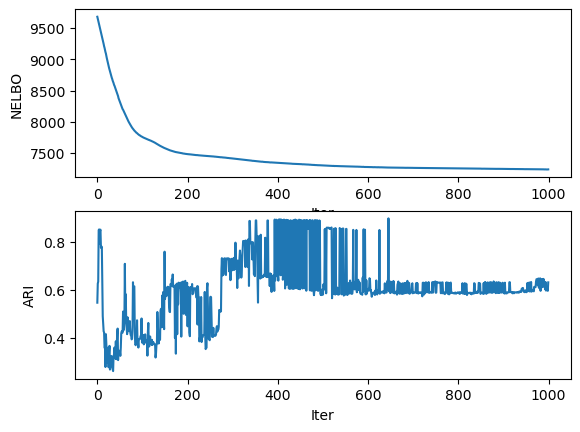

In [20]:
monitor_perf(scetm_perf, "NELBO")

# Task 4 compare ETM with NMF-Poisson
Now run NMF-Poisson also for 1000 iterations and compare the ARI scores with scETM over the 1000 iterations. While the NMF model converges to a local optimal after only 200 iterations, the ETM continues to improve. We observe some improvement from ETM over the NMF model especially after 200 iterations. This highlights the benefits of having the non-linear encoder function and perhaps the tri-factorization design in the ETM. When training on massive number of single-cell samples, using SGD on minibatches, ETM may confer bigger improvement. For this particular dataset, with batch-effect correction, a fine-tuned ETM can reach 0.90 ARI (Zhao et al., 2021).

Iter: 0 .. Loglik: -0.1674 .. ARI: 0.0000
Iter: 1 .. Loglik: -0.1576 .. ARI: 0.0000
Iter: 2 .. Loglik: -0.1395 .. ARI: 0.1444
Iter: 3 .. Loglik: -0.1162 .. ARI: 0.1491
Iter: 4 .. Loglik: -0.0966 .. ARI: 0.1485
Iter: 5 .. Loglik: -0.0795 .. ARI: 0.1520
Iter: 6 .. Loglik: -0.0607 .. ARI: 0.1193
Iter: 7 .. Loglik: -0.0433 .. ARI: 0.5639
Iter: 8 .. Loglik: -0.0303 .. ARI: 0.5746
Iter: 9 .. Loglik: -0.0207 .. ARI: 0.5766
Iter: 10 .. Loglik: -0.0131 .. ARI: 0.5719
Iter: 11 .. Loglik: -0.0067 .. ARI: 0.6295
Iter: 12 .. Loglik: -0.0016 .. ARI: 0.5975
Iter: 13 .. Loglik: 0.0023 .. ARI: 0.8566
Iter: 14 .. Loglik: 0.0052 .. ARI: 0.8482
Iter: 15 .. Loglik: 0.0075 .. ARI: 0.8048
Iter: 16 .. Loglik: 0.0093 .. ARI: 0.8256
Iter: 17 .. Loglik: 0.0109 .. ARI: 0.8711
Iter: 18 .. Loglik: 0.0122 .. ARI: 0.8247
Iter: 19 .. Loglik: 0.0133 .. ARI: 0.8245
Iter: 20 .. Loglik: 0.0143 .. ARI: 0.8219
Iter: 21 .. Loglik: 0.0152 .. ARI: 0.8267
Iter: 22 .. Loglik: 0.0159 .. ARI: 0.8317
Iter: 23 .. Loglik: 0.0166 .. A

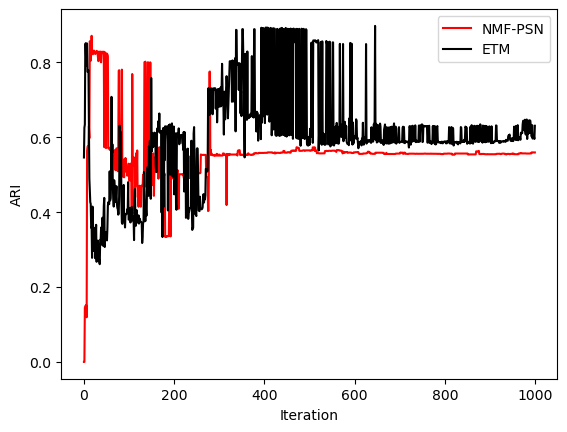

In [21]:
W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, K, niter=1000)
_, ax = plt.subplots()
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
scetm_perf_df = pd.DataFrame(data=scetm_perf, columns=['Iter', "NELBO", 'ARI'])
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.plot(scetm_perf_df["Iter"], scetm_perf_df["ARI"], color='black', label='ETM')
plt.xlabel("Iteration"); plt.ylabel("ARI")
ax.legend()
plt.show()


# Task 5 Generate t-SNE to visualize cell embeddings
Use the `model` object of ETM saved from the previous training over the 1000 iterations to infer final cell topic embedding $\mathbf{\theta}$ and generate the two-dimensional t-SNE plot. Also, use the `H` matrix from the NMF-Poisson model (trained after 1000 iterations) to generate another two-dimensional t-SNE plot. Compare them side-by-side as shown in plots below, respectively. We observe a slightly better separation of the alpha cells from other cells from the ETM compared to the NMF-Poisson model.

The plot was generated using a `Scanpy` function called `sc.tl.tsne`. Learn how to use it from its documentation.

In [ ]:
def get_tsne(cell_embed, adata, mytitle):
    ari = evaluate_ari(cell_embed, adata)
    sc.tl.tsne(adata, use_rep='cell_embed', n_pcs=10, use_fast_tsne=False)
    _, ax = plt.subplots(figsize=(7, 6))
    sc.pl.tsne(adata, color=["Celltype"],
               ax=ax, title=mytitle + ' (ARI: {:.2f})'.format(round(ari, 2)))

get_tsne(get_theta(model, X_tensor_normalized).cpu().numpy(), mp_anndata, 'ETM on MP')
get_tsne(H_nmf_psn.T, mp_anndata, 'NMF-Poisson on MP')

# Task 6 Plot heatmap for the cells under each topic
An alternative way to present the cell cluster is by heatmap. Heatmap is more effective in identifying which topics correlates well with which cell types. Generate a heatmap plot for the same cells-by-topics matrix $\mathbf{\theta}$ using *all of the 1886 cells over the 16 topics*. Your heatmap should look similar to the plot below, which was generated using `seaborn.clustermap`.

From here, we see that topic 7 correlates well with alpha cell type, topic 2 with endothelial, topic 6 with ductal cell type, and so forth. Note that you will get different topic indices matching with different cell types as the order of these topics are not the same at different runs.

In [ ]:
theta = get_theta(model, X_tensor_normalized)
theta_df = pd.DataFrame(theta.cpu().detach().numpy())

cell_types = pd.Series(list(mp_anndata.obs['Celltype']))
celltype_list = list(pd.unique(list(mp_anndata.obs['Celltype'])))
celltype_list.sort()
color_list = list(mp_anndata.uns['Celltype_colors'])
lut = dict(zip(celltype_list, color_list))
cell_type_colors = cell_types.map(lut)

g = clustermap(theta_df, center=0, cmap="RdBu_r", row_colors=cell_type_colors)

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Cell types',
           bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure,
           loc='best')

plt.show()

# Task 7 Plot heatmap for the top genes under each topic
To get cell-type-specific gene signature, we can visualize the genes by topics heatmap. Here we will plot the top 5 genes per topic in heatmap. Your heatmap should look similar to one below, which was generated using `seaborn.heatmap`. In plotting the heatmap, I capped the max value at 0.2 instead of letting it set to 1 to make the red intensities more prominent for some of the genes with low absolute value under some of the topics.

What cell-type-specific gene signatures can you find in your analysis? For example, from the heatmap we know that topic 7 corresponds to alpha cell type. The gene *Gcg*, which codes for protein Glucagon has the highest probability under that topic. Based on https://www.proteinatlas.org/ENSG00000115263-GCG, Glucagon is indeed a pancreatic hormone that counteracts the glucose-lowering action of insulin by stimulating glycogenolysis and gluconeogenesis!

In [ ]:
model.eval()
beta = model.get_beta()
beta_df = pd.DataFrame(beta.t().cpu().detach().numpy())
beta_df.index = genes
topN = 5
top_genes_topics = [beta_df.loc[beta_df[k].sort_values(ascending=False).head(topN).index] for k in range(K)]
top_genes_topics = pd.concat(top_genes_topics)

_, ax = plt.subplots(figsize=(6, 16))
g = heatmap(top_genes_topics, center=0,
            cmap="RdBu_r", vmax=0.2,
            linewidths=0.1)
plt.show()